Status: ✅ Done

## Exercise 7
In this exercise, we review the decision theory and then relate it to practical things by using `KNN` and `multinomial logistic regression (softmax)`.

> Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings("ignore")

### K-nearest neighbours (theory)

---

In this section, we first focus on the `knn` from a theoretical perspective. In the following section, we will get into more practical stuff. First, let's consider we are given following dataset:

![image info](images/img1.png)

Under the assumption that we use `euclidean distance` and `K=1`, how would the boundary look like? Let's see:

![image info](images/img2.png)

If we now change our assumption about `K` such that `K=3`, then let's consider following three possible new data observations:

**(a)** bullet with a majority of 2 to 1.

**(b)** open circle with a majority of 2 to 1.

**(c)** open circle with a majority of 3 to 0.

How would these look like in practice? Again, we can draw them:

![image info](images/img3.png)

Let's now formalize a bit how the `KNN` algorithm works. `KNN` by its definition is a `supervised` `non-parametric` machine learning algorithm. Note the word `non-parametric` which means there are no parameters to be estimated. On the other hand, when you want to make a prediction for a given test data point, you have to compute distance to all other training data points. In summary:

- Compute distance to all training points available. You can choose Euclidean distance or any other distance that suits you.

- Select K closest points

- Based on K selected K points decide which class you will assign the given point. If it is tight, then select class randomly (e.g. using choice function from random python module)

From a computtional complexity, the first step is `O(N)`, then sorting the distances is `O(NlogN)`. Yet, due to the `non-sequential` nature of the algorithm things can be parallelized quite nicely. For instance the computation of distances to each point since these are independent of each other (thus `non-sequential` algorithm). 

If we were to look at the problem more formally, we would write:

- Find the $K$ points in the training data that are closest to $x_0$ (test point) (call this set $N_0$)

- Estimate the `posterior probability` for class $j$ as the fraction of points in $N_0$ from class $j$:

$
\mathrm{P}\left(Y=j \mid X=x_0\right)=\frac{1}{K} \sum_{i \in \mathcal{N}_0} I\left(y_i=j\right)
$

- Choose the class with highest posterior probability (a.k.a. highest count)

One might wonder why this particular strategy actually works. If you want in depth understanding of this, I suggest you read my [note](https://ludekcizinsky.notion.site/Decision-theory-2c494a1de87b4973afe4e8f8aff4dc34). 


Let me first declare that we are entering a `theoretical` setting. This just means we assume we have know everything, for instance all possible outcomes and corresponding probabilities. In other words, do not try to relate it for now to the concrete ml algorithms, that will come lates. 

In machine learning we always have an objective for which we try to optimize our algorithm. This objective is called `loss`. `Loss` is just a function that based on your model's predictions tells you how well it is doing. The lower the loss, the better. In the lecture, you were expected to something called `expected` loss. This already sounds quite abstract, let me try to de-abstract it...

Recall from stats how you obtained expected value of some for isntance discrete random variable:

$
E[X] = \sum_i p(x_i)x_i
$

Same applies to continuous, instead of sum sign, you have integral. You go over each possible outcome and then weight it by its probability. Also recall, that if we apply some transformation $g$ on the given random variable, we end up with:

$
E[g(X)] = \sum_i p(x_i)g(x_i)
$

In our case, our transformation is $L$ - the loss function. This loss function takes as an input features and given class $Y$, therefore we can rewrite is as follows (assuming we have one discrete feature for simplicity)

$
E[L(X, Y)] = \sum_x \sum_y p(x, y)L(x, y)
$

In the lecture, it has been proven that in order to minimize the expected loss, it is enough to minimize its adjusted version, i.e., expected posterior loss $E[L(X, Y) | X]$ and the way to do this in theory is to predict the class with highest posterior probability. And the way to compute the posterior probability $P(Y | X)$ is through `Bayes` theorem:

$
P(Y | X) = \frac{P(X | Y)P(Y)}{P(X)}
$

And therefore any classifier that uses the above formula to compute posterior probabilities and then uses the decision to predict class with the highest posterior probability is called `Bayes classifier`. All up to this point, everything has been theoretical. Meaning, in practice all the terms that you see the in `Bayes` theorem's numerator has to be estimated (denomitor is just a of all numerators for all the classes).

So in practice, your goal as machine learning practioner is to get as close as possible to the `Bayes classifier` because that is in theory the best you can do. As in normal life, there are many ways how you can get to this goal:

- **generative models** - you model $P(X |Y)$ (likelihood) and $P(Y)$ (prior) and use it to compute the $P(Y | X)$. These models are generative because if you know the likelihood and prior, you also must know joint distribution $P(X, Y) = P(X | Y)P(Y)$. Therefore, you can sample from the model, i.e., you give it a probability and it returns a concrete sample. Examples of such models are `LDA` or `QDA`. (will talk about these later in the course)

- **discriminative** - these model the posterior probability directly - yes `KNN` belongs to this class

- **discriminant function** - these directly predict class - therefore no information about the uncertainity

Bottom line: All of these approaches have its pros and cons and we will discuss them lates in the course. This has been a lot of stuff to digest, so let's stop here and do a section summary.

> Section summary

Main highlight of this section should be that you understand how `KNN` works and that we call it a `discriminative` model because it directly models `posterior probability`. A very nice bonus would be if you would be able to explain how we go from the theoretical expected loss to minimizing it through bayes classifier and what role does actually bayes classifier play in the context of the models we learn about in this class.

### K-nearest neighbours (practice)

---

Let's now consider the following figure representing scatter plot of the provided data:

![image info](images/img4.png)

Now, if we have an input data point $(x1, x2) = (3, 3.5)$, what would be our estimate for posterior probabilities for each class? Just looking at the figure, my rough estimate would be:

- $P(Y = Black | X) = 0.1$
- $P(Y = Blue | X) = 0.2$
- $P(Y = Red | X) = 0.7$

Thus we would classify the given point as `red class`. Let's try to verify this guess using actual code, we start by loading data:

In [2]:
# Load training data
training = pd.read_csv("Ex1-training.csv")
X_train, y_train = training[["x1", "x2"]], training["y"]

# Load test data
test = pd.read_csv("Ex1-test.csv")
X_test, y_test = test[["x1", "x2"]],test["y"]

Now, we are going to fit a model using `sklearn`:

In [3]:
# Define mapping between encoding and classes
mapping = {
    1: "Black",
    2: "Red",
    3: "Blue"
}

# Model definition and fit
knn10 = KNeighborsClassifier(10).fit(X_train, y_train)

# Our sample input
to_predict = pd.DataFrame({'x1': [3], 'x2': [3.5]})

# Predict
probs = knn10.predict_proba(to_predict)

# Show results
print("Class | Posterior")
print("{:<5} | {:^10}".format(mapping[1], probs[0][0]))
print("{:<5} | {:^10}".format(mapping[2], probs[0][1]))
print("{:<5} | {:^10}".format(mapping[3], probs[0][2]))

Class | Posterior
Black |    0.5    
Red   |    0.5    
Blue  |    0.0    


So I was actually bit off since `red` seems to have a lowe posterior than my initial estimate. As a next step, let's visualize our fitted `KNNs`:

In [4]:
# Fir also a KNN with K = 5
knn5 = KNeighborsClassifier(5).fit(X_train, y_train)

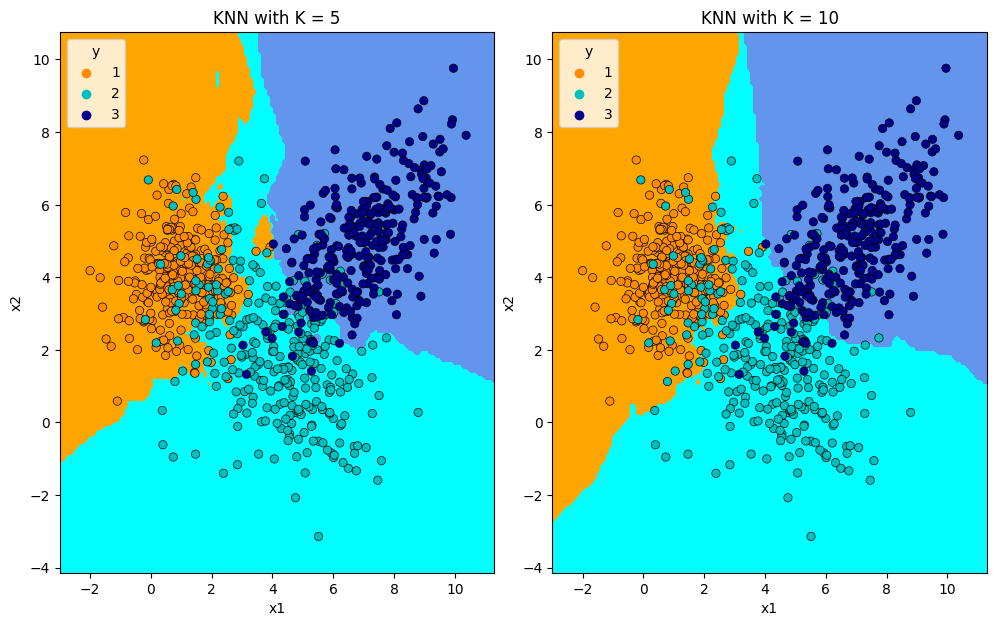

In [5]:
# Define subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 6));
plt.tight_layout();

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define clfs
clfs = [knn5, knn10]

# Step size in grid
h = .1

# Create a grid
x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for i, K, clf in zip([0, 1], [5, 10], clfs):

    # Plot decision regions
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax[i].contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[i])
    ax[i].set_title(f"KNN with K = {K}")

Interesting, there is certainly a slight difference between the two. Let's now examine more in depth role of `K` when it comes to `training` and `test` error rate:

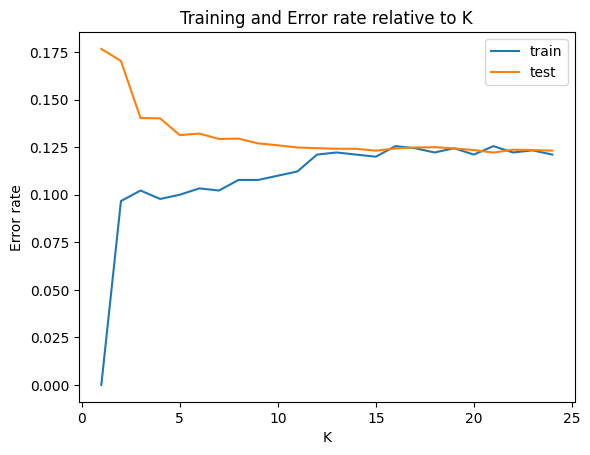

In [6]:
# Define range of Ks we want to inspect
Ks = [i for i in range(1, 25)]

# Store training and test error in y1 and y2
y1 = []
y2 = []
for K in Ks:
    clf = KNeighborsClassifier(K)
    clf.fit(X_train, y_train);
    acc_train = 1 - accuracy_score(y_train, clf.predict(X_train))
    acc_test = 1 - accuracy_score(y_test, clf.predict(X_test))
    y1.append(acc_train)
    y2.append(acc_test)

# Visualize the data
plt.plot(Ks, y1, label = "train");
plt.plot(Ks, y2, label = "test");
plt.xlabel("K");
plt.ylabel("Error rate")
plt.title("Training and Error rate relative to K");
plt.legend();

As we can see, for `low K`, we have high variance. This makes sense as we simply do not consider enough information. In addition, if `K` would be equal to the sample size, then whichever class has highest count in training would be always predicted. Therefore, we need to find some reasonable balance. From the above plot, reasonable balance seems to be around `K = 12`.

A K-Nearest Neighbors (KNN) classifier with a low number of k neighbors usually has high variance and low bias.

Here's why:

High Variance: With a smaller value of k, the prediction can be highly sensitive to noise in the dataset. A small change in the training set can lead to a significant change in the prediction, especially if that change affects one of the k nearest neighbors. This results in a high variance scenario.

Low Bias: Since the classifier is heavily relying on a small number of neighbors, it's trying to fit very closely to the training data, which leads to low bias.

> Section summary

In this section, we focused on the practical stuff: how to fit `KNN`, how to plot decision boundaries as well as how to choose `K`.

### Multiclass classification with multinomial logistic regression (Softmax)

---

In this final section, we briefly go over `multionomial logistic regression` (a.k.a. softmax regression). First, let's discuss its formula. Compare to `KNN`, softmax regression is parametric, but they both belong to the family of models called `discriminative` models since they model the posterior probability directly. Yet, their approach is different. There is no rule when to use which. From a personal experience, whenever, there is a need for a more complex decision boundary, I try `KNN`. On the other hand, one can also have a complex decision boundary by adding non-linearity to the features of the softmax regression.

In the book, you were introduced to two ways of defining `multionomial` logistic regression: `baseline` and `softmax` coding. The end result, i.e., the predictions are the same, but the way you get to them is different. I personally prefer to use softmax encoding which is simply that we compute posterior for each class as follows:

$
\operatorname{Pr}(Y=k \mid X=x)=\frac{e^{\beta_{k 0}+\beta_{k 1} x_1+\cdots+\beta_{k p} x_p}}{\sum_{l=1}^K e^{\beta_{l 0}+\beta_{l 1} x_1+\cdots+\beta_{l p} x_p}}
$

It is important to note that in this case, you are estimating `p` parameters for each class. If we decompose the formula then in denominator, you sum over all numerators. Therefore we can just compute it once. This is to ensure that the sum of all posterior probabilities is 1. In the numerator we map the result of linear combination of features and parameters to the positive range using the exponential function. Finally, to make a prediction we can do a simple matrix multiplication:

$
\text{probabilities} = \sigma(X \theta)
$

Here $X$ is $n \times p$ design matrix, $\theta$ is $p \times K$ matrix and as a result we get $n \times K$ matrix where each row is a vector of real $\eta=\left(\eta_1, \ldots, \eta_k\right)$ that we need to map using softmax to probabilities. Of course, if we look at log-odds:

$
\log \left(\frac{\operatorname{Pr}(Y=k \mid X=x)}{\operatorname{Pr}\left(Y=k^{\prime} \mid X=x\right)}\right)=\left(\beta_{k 0}-\beta_{k^{\prime} 0}\right)+\left(\beta_{k 1}-\beta_{k^{\prime} 1}\right) x_1+\cdots+\left(\beta_{k p}-\beta_{k^{\prime} p}\right) x_p
$

We can again see that the log odds ratio is linear. Let's now fit a softmax regression model at the provided data:

In [7]:
m2 =  LogisticRegression(penalty='none', multi_class='multinomial').fit(X_train, y_train)

Now, we can now visualize the decision border along with the test data as follows:

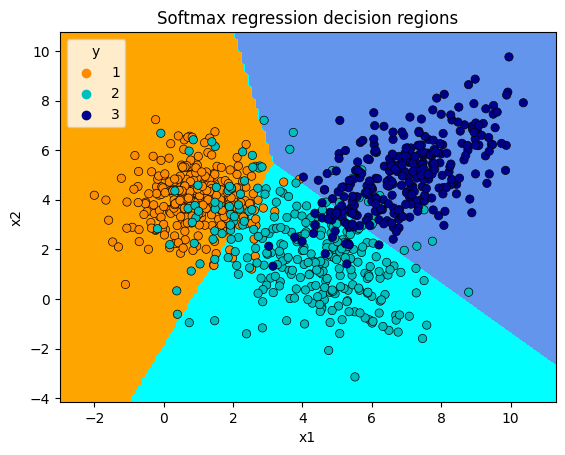

In [8]:
# Define subplots
fig, ax = plt.subplots();

# Plot decision regions
Z = m2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_title(f"Softmax regression decision regions");

As we can see, we get linear boundaries - as expected. Let's add some non-linearity:

In [9]:
m3 = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(penalty='none', multi_class='multinomial')).fit(X_train, y_train)

degree 2 means we have x_1, x_2 = [1, x_1, x_2, x_1^2, x_2^2, x_1x_2]

And again visualize it:

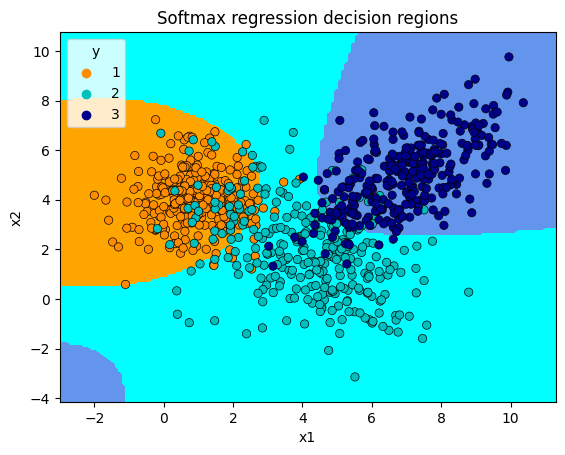

In [10]:
# Define subplots
fig, ax = plt.subplots();

# Plot decision regions
Z = m3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_title(f"Softmax regression decision regions");

Seems overall as a better fit. :)

> Section summary

After reading this section, you should understand the `softmax` regression formula and be able to fit the softmax regression model.

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4323d2e4-53c1-4ff3-b2c1-322e0f14bddc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>